In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

np_convert_dir = 'np_convert'
width_threshold = 350

# Function to pad a matrix
def pad_matrix(matrix, target_height=50, target_width=350):
    padding_height = max(target_height - matrix.shape[0], 0)
    padding_width = max(target_width - matrix.shape[1], 0)
    return np.pad(matrix, 
                  pad_width=((0, padding_height), (0, padding_width)), 
                  mode='constant', 
                  constant_values=0)

# Custom Dataset Class
class MyDataset(Dataset):
    def __init__(self, np_convert_dir, width_threshold):
        self.data = []
        for file in os.listdir(np_convert_dir):
            if file.endswith('.npy'):
                file_path = os.path.join(np_convert_dir, file)
                matrix = np.load(file_path)
                
                # Filter matrices with width less than the threshold
                if matrix.shape[1] < width_threshold:
                    padded_matrix = pad_matrix(matrix)
                    self.data.append(padded_matrix)

        # Convert list of numpy arrays to a numpy array and then to a torch Tensor
        self.data = torch.tensor(np.array(self.data), dtype=torch.float32).unsqueeze(1)  # Add channel dimension

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Initialize Dataset
dataset = MyDataset(np_convert_dir, width_threshold)

# Create a DataLoader
batch_size = 16  # You can adjust the batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [2]:
# Initialize Dataset
dataset = MyDataset(np_convert_dir, width_threshold)

# Print out the total number of matrices in the dataset
total_matrices = len(dataset)
print(f"Total number of matrices in the dataset after projection: {total_matrices}")


Total number of matrices in the dataset after projection: 356


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  
        out = out + identity
        return out

class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 25 * 175 * 256)
        self.unflatten = nn.Unflatten(1, (256, 25, 175))

        self.upsample1 = nn.Upsample(scale_factor=(2, 1))
        self.conv1 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.relu1 = nn.LeakyReLU(0.01)
        self.dropout1 = nn.Dropout(0.3)

        self.resblock1 = ResidualBlock(256)
        self.resblock2 = ResidualBlock(256)

        self.upsample2 = nn.Upsample(scale_factor=(1, 2))
        self.conv2 = nn.Conv2d(512, 128, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.LeakyReLU(0.01)
        self.dropout2 = nn.Dropout(0.3)

        self.resblock3 = ResidualBlock(128)

        self.conv3 = nn.Conv2d(128, 1, kernel_size=(3, 3), padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.unflatten(x)

        # First upsample and convolution
        x1 = self.upsample1(x)
        x1 = self.conv1(x1)
        x1 = self.bn1(x1)
        x1 = self.relu1(x1)
        x1 = self.dropout1(x1)  # Applying dropout

        # Residual blocks
        x2 = self.resblock1(x1)
        x2 = self.resblock2(x2)

        # Concatenate skip connection
        x3 = torch.cat([x2, x1], dim=1)

        # Second upsample and convolution
        x3 = self.upsample2(x3)
        x3 = self.conv2(x3)
        x3 = self.bn2(x3)
        x3 = self.relu2(x3)
        x3 = self.dropout2(x3)  # Applying dropout

        x3 = self.resblock3(x3)

        x3 = self.conv3(x3)
        x3 = nn.Sigmoid()(x3)
        return x3


# Discriminator Class
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128 * 13 * 88, 1),  # Updated input size
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
z_dim = 100
img_shape = (1, 50, 350)
generator = Generator(z_dim)
discriminator = Discriminator(img_shape)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)


In [4]:
num_epochs = 1000
print_interval = 50  # Adjust this to control how often you print the loss
discriminator_update_frequency = 4  # Update discriminator less frequently

# Check for GPU availability
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Move models to the chosen device
generator = generator.to(device)
discriminator = discriminator.to(device)

# Initialize lists for storing metrics
d_losses = []
g_losses = []
real_accuracies = []
fake_accuracies = []

import matplotlib.pyplot as plt

def plot_generated_images(epoch, generator, fixed_noise, device, num_images=16):
    # Tell the generator we are in eval mode
    generator.eval()

    # Generate fake images
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
    
    # Process and plot each image
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(f"Generated Images at Epoch {epoch}")
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(fake_images[cnt, 0, :, :], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

    # Set the generator back to train mode
    generator.train()

# Create a fixed noise vector for generating images
fixed_noise = torch.randn(16, z_dim, 1, 1, device=device)


# Training loop
for epoch in range(num_epochs):
    # Initialize variables to accumulate losses and accuracies
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    real_correct = 0
    fake_correct = 0
    total_real = 0
    total_fake = 0

    for i, real_images in enumerate(dataloader):
        current_batch_size = real_images.size(0)

        # Move data to the appropriate device and create labels for real and fake data
        real_images = real_images.to(device)
        real_labels = torch.ones(current_batch_size, 1, device=device)
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        discriminator.zero_grad()

        # Compute discriminator loss on real images
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        d_loss_real.backward()
        real_predictions = (outputs > 0.5).float()
        real_correct += (real_predictions == real_labels).sum().item()
        total_real += current_batch_size

        # Generate fake images
        z = torch.randn(current_batch_size, z_dim, device=device)
        fake_images = generator(z)

        # Compute discriminator loss on fake images
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        d_loss_fake.backward()
        fake_predictions = (outputs < 0.5).float()
        fake_correct += (fake_predictions == fake_labels).sum().item()
        total_fake += current_batch_size

        # Update discriminator based on update frequency
        if i % discriminator_update_frequency == 0:
            optimizer_d.step()

        # -----------------
        # Train Generator
        # -----------------
        generator.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

        # Print loss stats
        if i % print_interval == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} \
                  Loss D: {d_loss_real.item() + d_loss_fake.item()}, Loss G: {g_loss.item()}")
        
        # Accumulate losses for the epoch
        epoch_d_loss += (d_loss_real.item() + d_loss_fake.item())
        epoch_g_loss += g_loss.item()
    

    
    # Compute average losses and accuracies for the epoch
    d_losses.append(epoch_d_loss / len(dataloader))
    g_losses.append(epoch_g_loss / len(dataloader))
    real_accuracies.append((real_correct / total_real) * 100)
    fake_accuracies.append((fake_correct / total_fake) * 100)
    
    # Print discriminator's success rate every 10 epochs
    if epoch % 5 == 0:

        plot_generated_images(epoch, generator, fixed_noise, device)
        
        real_acc = (real_correct / total_real) * 100
        fake_acc = (fake_correct / total_fake) * 100
        print(f"Epoch [{epoch}/{num_epochs}] \
              Real Acc: {real_acc:.2f}%, Fake Acc: {fake_acc:.2f}%")

    # Reset counters after each epoch
    real_correct = 0
    fake_correct = 0
    total_real = 0
    total_fake = 0

# Add any additional code needed for saving models, tracking progress, etc.


Using GPU: NVIDIA GeForce RTX 3080
Epoch [0/1000] Batch 0/23                   Loss D: 1.3566068410873413, Loss G: 2.3029024600982666
Epoch [0/1000]               Real Acc: 63.20%, Fake Acc: 37.64%
Epoch [1/1000] Batch 0/23                   Loss D: 1.226878046989441, Loss G: 0.9252141714096069
Epoch [2/1000] Batch 0/23                   Loss D: 1.219167709350586, Loss G: 0.6277535557746887
Epoch [3/1000] Batch 0/23                   Loss D: 0.8834527134895325, Loss G: 0.9767117500305176
Epoch [4/1000] Batch 0/23                   Loss D: 0.566815972328186, Loss G: 1.530390977859497
Epoch [5/1000] Batch 0/23                   Loss D: 0.2712917923927307, Loss G: 2.2228713035583496
Epoch [5/1000]               Real Acc: 99.16%, Fake Acc: 0.00%
Epoch [6/1000] Batch 0/23                   Loss D: 0.1255910024046898, Loss G: 2.994349479675293
Epoch [7/1000] Batch 0/23                   Loss D: 0.0527533832937479, Loss G: 3.243907928466797
Epoch [8/1000] Batch 0/23                   Loss D: 

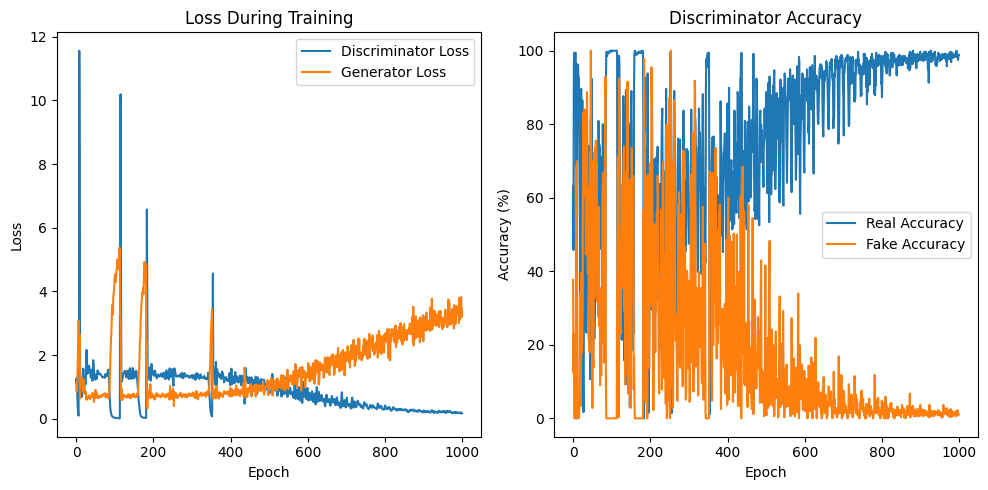

In [14]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 5))

# Plot discriminator and generator loss
plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot discriminator accuracy
plt.subplot(1, 2, 2)
plt.plot(real_accuracies, label='Real Accuracy')
plt.plot(fake_accuracies, label='Fake Accuracy')
plt.title("Discriminator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
# # loading model script for later use

# if torch.cuda.is_available():
#     device = torch.device("cuda:0")  # Use the first GPU
#     print("Using GPU:", torch.cuda.get_device_name(0))
# else:
#     device = torch.device("cpu")
#     print("GPU not available, using CPU instead.")


# generator = torch.load('generator_model.pth', map_location=device)
# discriminator = torch.load('discriminator_model.pth', map_location=device)

# generator.to(device)
# discriminator.to(device)


Using GPU: NVIDIA GeForce RTX 3080


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=146432, out_features=1, bias=True)
    (8): Sigmoid()
  )
)

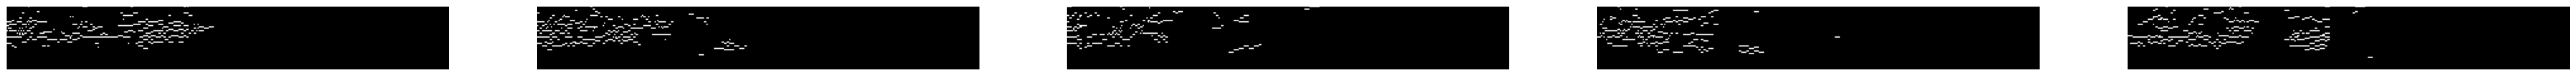

In [11]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def show_images(images, num_images=5, threshold=0.5):
    plt.figure(figsize=(50, 50))  # Adjust figsize as needed
    binary_images = []

    for i in range(num_images):
        img = images[i].squeeze().detach().cpu().numpy()  # Remove channel dimension and convert to numpy
        # Convert to binary
        binary_img = (img > threshold).astype(int)
        binary_images.append(binary_img)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(binary_img, cmap='gray')
        plt.axis('off')
    
    plt.show()
    return binary_images

# Generate random noise
z = torch.randn(5, z_dim, device=device)  # Adjust 'z_dim' to match your generator's input dimension

# Generate images from the noise
generator.eval()  # Set the generator to eval mode
with torch.no_grad():  # Disable gradient computation
    fake_images = generator(z)

# Display and get binary images
binary_images = show_images(fake_images)

# Save binary images as .npy files
for i, img in enumerate(binary_images):
    np.save(f'binary_image_{i}.npy', img)


In [16]:
# Save the entire model
torch.save(generator, 'generator_model.pth')
torch.save(discriminator, 'discriminator_model.pth')
# Save the model state dictionaries
torch.save(generator.state_dict(), 'generator_state_dict.pth')
torch.save(discriminator.state_dict(), 'discriminator_state_dict.pth')
